# Online SVR
<b>reference</b></br>
[1]J. Ma, J. Theiler, and S. Perkins, “Accurate On-line Support Vector Regression,” Neural Computation, vol. 15, no. 11, pp. 2683–2703, Nov. 2003, doi: 10.1162/089976603322385117.

In [9]:
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm

<AxesSubplot:>

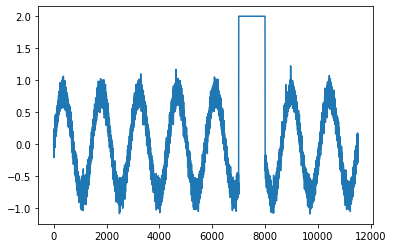

In [50]:
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 8000):
    y[i] = 2.0
series.plot.line()

100%|██████████| 5730/5730 [00:04<00:00, 1265.67it/s]


<AxesSubplot:>

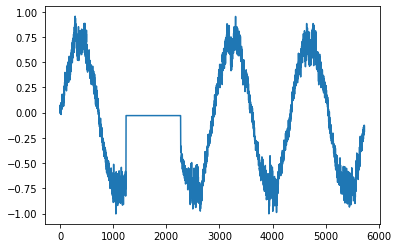

In [58]:
# Functional Test
svr = OnlineSVR(series[0:4*1440])
Xhat = []
for i in tqdm(range(4 * 1440, 8 * 1440)):
    xhat = svr.update(series[i])
    Xhat.append(xhat)
pd.Series(Xhat).plot.line()

<AxesSubplot:>

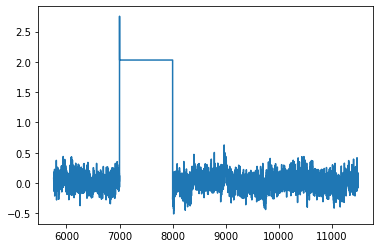

In [61]:
# recon error distribution
(series[4*1440:8*1440] - Xhat).plot.line()

SVR生成的重构误差中，异常值持续存在，且对带外异常敏感.

# Code Repo

In [57]:
class OnlineSVR:
    '''
        Initialize
    '''
    def __init__(self, series, num_features=30):
        self.svr = OSVR(numFeatures = num_features, C = 2, eps = 0.01, kernelParam = 1, bias = 0, debug = False)
        self.window = series[-num_features:]
        for i in tqdm(range(0, min(series.size, 1 * 1440) - num_features)):
            # slow, so use sampling here.
            if (i % 10 == 0):
                self.svr.learn(series[i:i+num_features], series[i+num_features])
    
    '''
        Update
    '''
    def update(self, x):
        xhat = self.svr.predict(self.window)
        def update_array(array, update):
            updated = np.roll(array, -1)
            updated[-1] = update
            return updated
        self.window = update_array(self.window, x).tolist()
        return x - xhat[0,0]

In [56]:
def sign(x):
    """ Returns sign. Numpys sign function returns 0 instead of 1 for zero values. :( """
    if x >= 0:
        return 1
    else:
        return -1

In [55]:
class OSVR:
    def __init__(self, numFeatures, C, eps, kernelParam, bias = 0, debug = False):
        # Configurable Parameters
        self.numFeatures = numFeatures
        self.C = C
        self.eps = eps
        self.kernelParam = kernelParam
        self.bias = bias
        self.debug = debug
        
        if self.debug:
            print('SELF',self.C,self.eps,self.kernelParam)
        # Algorithm initialization
        self.numSamplesTrained = 0
        self.weights = np.array([])
        
        # Samples X (features) and Y (truths)
        self.X = list()
        self.Y = list()
        # Working sets, contains indices pertaining to X and Y
        self.supportSetIndices = list()
        self.errorSetIndices = list()
        self.remainderSetIndices = list()
        self.R = np.matrix([])

    def findMinVariation(self, H, beta, gamma, i):
        """ Finds the variations of each sample to the new set.
        Lc1: distance of the new sample to the SupportSet
        Lc2: distance of the new sample to the ErrorSet
        Ls(i): distance of the support samples to the ErrorSet/RemainingSet
        Le(i): distance of the error samples to the SupportSet
        Lr(i): distance of the remaining samples to the SupportSet
        """
        # Find direction q of the new sample
        q = -sign(H[i])
        # Compute variations
        Lc1 = self.findVarLc1(H, gamma, q, i)
        q = sign(Lc1)
        Lc2 = self.findVarLc2(H, q, i)
        Ls = self.findVarLs(H, beta, q)
        Le = self.findVarLe(H, gamma, q)
        Lr = self.findVarLr(H, gamma, q)
        # Check for duplicate minimum values, grab one with max gamma/beta, set others to inf
        # Support set
        if Ls.size > 1:
            minS = np.abs(Ls).min()
            results = np.array([k for k,val in enumerate(Ls) if np.abs(val)==minS])
            if len(results) > 1:
                betaIndex = beta[results+1].argmax()
                Ls[results] = q*np.inf
                Ls[results[betaIndex]] = q*minS
        # Error set
        if Le.size > 1:
            minE = np.abs(Le).min()
            results = np.array([k for k,val in enumerate(Le) if np.abs(val)==minE])
            if len(results) > 1:
                errorGamma = gamma[self.errorSetIndices]
                gammaIndex = errorGamma[results].argmax()
                Le[results] = q*np.inf
                Le[results[gammaIndex]] = q*minE
        # Remainder Set
        if Lr.size > 1:
            minR = np.abs(Lr).min()
            results = np.array([k for k,val in enumerate(Lr) if np.abs(val)==minR])
            if len(results) > 1:
                remGamma = gamma[self.remainderSetIndices]
                gammaIndex = remGamma[results].argmax()
                Lr[results] = q*np.inf
                Lr[results[gammaIndex]] = q*minR
        
        # Find minimum absolute variation of all, retain signs. Flag determines set-switching cases.
        minLsIndex = np.abs(Ls).argmin()
        minLeIndex = np.abs(Le).argmin()
        minLrIndex = np.abs(Lr).argmin()
        minIndices = [None, None, minLsIndex, minLeIndex, minLrIndex]
        minValues = np.array([Lc1, Lc2, Ls[minLsIndex], Le[minLeIndex], Lr[minLrIndex]])

        if np.abs(minValues).min() == np.inf:
            if self.debug:
                print('No weights to modify! Something is wrong.')
            sys.exit()
        flag = np.abs(minValues).argmin()
        if self.debug:
            print('MinValues',minValues)
        return minValues[flag], flag, minIndices[flag]

    def findVarLc1(self, H, gamma, q, i):
        # weird hacks below
        Lc1 = np.nan
        if gamma.size < 2:
            g = gamma
        else:
            g = gamma.item(i)
        # weird hacks above

        if  g <= 0:
            Lc1 = np.array(q*np.inf)
        elif H[i] > self.eps and -self.C < self.weights[i] and self.weights[i] <= 0:
            Lc1 = (-H[i] + self.eps) / g
        elif H[i] < -self.eps and 0 <= self.weights[i] and self.weights[i] <= self.C:
            Lc1 = (-H[i] - self.eps) / g
        elif self.debug:
            print('Something is weird.')
            print('i',i)
            print('q',q)
            print('gamma',gamma)
            print('g',g)
            print('H[i]',H[i])
            print('weights[i]',self.weights[i])
        
        if np.isnan(Lc1):
            Lc1 = np.array(q*np.inf)
        return Lc1.item()

    def findVarLc2(self, H, q, i):
        if len(self.supportSetIndices) > 0:
            if q > 0:
                Lc2 = -self.weights[i] + self.C
            else:
                Lc2 = -self.weights[i] - self.C
        else:
            Lc2 = np.array(q*np.inf)
        if np.isnan(Lc2):
            Lc2 = np.array(q*np.inf)
        return Lc2

    def findVarLs(self, H, beta, q):
        if len(self.supportSetIndices) > 0 and len(beta) > 0:
            Ls = np.zeros([len(self.supportSetIndices),1])
            supportWeights = self.weights[self.supportSetIndices]
            supportH = H[self.supportSetIndices]
            for k in range(len(self.supportSetIndices)):
                if q*beta[k+1] == 0:
                    Ls[k] = q*np.inf
                elif q*beta[k+1] > 0:
                    if supportH[k] > 0:
                        if supportWeights[k] < -self.C:
                            Ls[k] = (-supportWeights[k] - self.C) / beta[k+1]
                        elif supportWeights[k] <= 0:
                            Ls[k] = -supportWeights[k] / beta[k+1]
                        else:
                            Ls[k] = q*np.inf
                    else:
                        if supportWeights[k] < 0:
                            Ls[k] = -supportWeights[k] / beta[k+1]
                        elif supportWeights[k] <= self.C:
                            Ls[k] = (-supportWeights[k] + self.C) / beta[k+1]
                        else:
                            Ls[k] = q*np.inf
                else:
                    if supportH[k] > 0:
                        if supportWeights[k] > 0:
                            Ls[k] = -supportWeights[k] / beta[k+1]
                        elif supportWeights[k] >= -self.C:
                            Ls[k] = (-supportWeights[k] - self.C) / beta[k+1]
                        else:
                            Ls[k] = q*np.inf
                    else:
                        if supportWeights[k] > self.C:
                            Ls[k] = (-supportWeights[k] + self.C) / beta[k+1]
                        elif supportWeights[k] >= self.C:
                            Ls[k] = -supportWeights[k] / beta[k+1]
                        else:
                            Ls[k] = q*np.inf
        else:
            Ls = np.array([q*np.inf])

        # Correct for NaN
        Ls[np.isnan(Ls)] = q*np.inf
        if Ls.size > 1:
            Ls.shape = (len(Ls),1)
            # Check for broken signs
            for val in Ls:
                if sign(val) == -sign(q) and val != 0:
                    if self.debug:
                        print('Sign mismatch error in Ls! Exiting.')
                    sys.exit()
        # print('findVarLs',Ls)
        return Ls
        
    def findVarLe(self, H, gamma, q):
        if len(self.errorSetIndices) > 0:
            Le = np.zeros([len(self.errorSetIndices),1])
            errorGamma = gamma[self.errorSetIndices]
            errorWeights = self.weights[self.errorSetIndices]
            errorH = H[self.errorSetIndices]
            for k in range(len(self.errorSetIndices)):
                if q*errorGamma[k] == 0:
                    Le[k] = q*np.inf
                elif q*errorGamma[k] > 0:
                    if errorWeights[k] > 0:
                        if errorH[k] < -self.eps:
                            Le[k] = (-errorH[k] - self.eps) / errorGamma[k]
                        else:
                            Le[k] = q*np.inf
                    else:
                        if errorH[k] < self.eps:
                            Le[k] = (-errorH[k] + self.eps) / errorGamma[k]
                        else:
                            Le[k] = q*np.inf
                else:
                    if errorWeights[k] > 0:
                        if errorH[k] > -self.eps:
                            Le[k] = (-errorH[k] - self.eps) / errorGamma[k]
                        else:
                            Le[k] = q*np.inf
                    else:
                        if errorH[k] > self.eps:
                            Le[k] = (-errorH[k] + self.eps) / errorGamma[k]
                        else:
                            Le[k] = q*np.inf
        else:
            Le = np.array([q*np.inf])

        # Correct for NaN
        Le[np.isnan(Le)] = q*np.inf
        if Le.size > 1:
            Le.shape = (len(Le),1)
            # Check for broken signs
            for val in Le:
                if sign(val) == -sign(q) and val != 0:
                    if self.debug:
                        print('Sign mismatch error in Le! Exiting.')
                    sys.exit()
        # print('findVarLe',Le)
        return Le

    def findVarLr(self, H, gamma, q):
        if len(self.remainderSetIndices) > 0:
            Lr = np.zeros([len(self.remainderSetIndices),1])
            remGamma = gamma[self.remainderSetIndices]
            remH = H[self.remainderSetIndices]
            for k in range(len(self.remainderSetIndices)):
                if q*remGamma[k] == 0:
                    Lr[k] = q*np.inf
                elif q*remGamma[k] > 0:
                    if remH[k] < -self.eps:
                        Lr[k] = (-remH[k] - self.eps) / remGamma[k]
                    elif remH[k] < self.eps:
                        Lr[k] = (-remH[k] + self.eps) / remGamma[k]
                    else:
                        Lr[k] = q*np.inf
                else:
                    if remH[k] > self.eps:
                        Lr[k] = (-remH[k] + self.eps) / remGamma[k]
                    elif remH[k] > -self.eps:
                        Lr[k] = (-remH[k] - self.eps) / remGamma[k]
                    else:
                        Lr[k] = q*np.inf
        else:
            Lr = np.array([q*np.inf])

        # Correct for NaN
        Lr[np.isnan(Lr)] = q*np.inf
        if Lr.size > 1:
            Lr.shape = (len(Lr),1)
            # Check for broken signs
            for val in Lr:
                if sign(val) == -sign(q) and val != 0:
                    if self.debug:
                        print('Sign mismatch error in Lr! Exiting.')
                    sys.exit()
        # print('findVarLr',Lr)
        return Lr

    def computeKernelOutput(self, set1, set2):
        """Compute kernel output. Uses a radial basis function kernel."""
        X1 = np.matrix(set1)
        X2 = np.matrix(set2).T
        # Euclidean distance calculation done properly
        [S,R] = X1.shape
        [R2,Q] = X2.shape
        X = np.zeros([S,Q])
        if Q < S:
            copies = np.zeros(S,dtype=int)
            for q in range(Q):
                if self.debug:
                    print('X1',X1)
                    print('X2copies',X2.T[q+copies,:])
                    print('power',np.power(X1-X2.T[q+copies,:],2))
                xsum = np.sum(np.power(X1-X2.T[q+copies,:],2),axis=1)
                xsum.shape = (xsum.size,)
                X[:,q] = xsum
        else:
            copies = np.zeros(Q,dtype=int)
            for i in range(S):
                X[i,:] = np.sum(np.power(X1.T[:,i+copies]-X2,2),axis=0)
        X = np.sqrt(X)
        y = np.matrix(np.exp(-self.kernelParam*X**2))
        if self.debug:
            print('distance',X)
            print('kernelOutput',y)
        return y
    
    def predict(self, newSampleX):
        X = np.array(self.X)
        newX = np.array(newSampleX)
        weights = np.array(self.weights)
        weights.shape = (weights.size,1)
        if self.numSamplesTrained > 0:
            y = self.computeKernelOutput(X, newX)
            return (weights.T @ y).T + self.bias
        else:
            return np.zeros_like(newX) + self.bias

    def computeMargin(self, newSampleX, newSampleY):
        fx = self.predict(newSampleX)
        newSampleY = np.array(newSampleY)
        newSampleY.shape = (newSampleY.size, 1)
        if self.debug:
            print('fx',fx)
            print('newSampleY',newSampleY)
            print('hx',fx-newSampleY)
        return fx-newSampleY

    def computeBetaGamma(self,i):
        """Returns beta and gamma arrays."""
        # Compute beta vector
        X = np.array(self.X)
        Qsi = self.computeQ(X[self.supportSetIndices,:], X[i,:])
        if len(self.supportSetIndices) == 0 or self.R.size == 0:
            beta = np.array([])
        else:
            beta = -self.R @ np.append(np.matrix([1]),Qsi,axis=0)
        # Compute gamma vector
        Qxi = self.computeQ(X, X[i,:])
        Qxs = self.computeQ(X, X[self.supportSetIndices,:])
        if len(self.supportSetIndices) == 0 or Qxi.size == 0 or Qxs.size == 0 or beta.size == 0:
            gamma = np.array(np.ones_like(Qxi))
        else:
            gamma = Qxi + np.append(np.ones([self.numSamplesTrained,1]), Qxs, 1) @ beta

        # Correct for NaN
        beta[np.isnan(beta)] = 0
        gamma[np.isnan(gamma)] = 0
        if self.debug:
            print('R',self.R)
            print('beta',beta)
            print('gamma',gamma)
        return beta, gamma

    def computeQ(self, set1, set2):
        set1 = np.matrix(set1)
        set2 = np.matrix(set2)
        Q = np.matrix(np.zeros([set1.shape[0],set2.shape[0]]))
        for i in range(set1.shape[0]):
            for j in range(set2.shape[0]):
                Q[i,j] = self.computeKernelOutput(set1[i,:],set2[j,:])
        return np.matrix(Q)
        
    def adjustSets(self, H, beta, gamma, i, flag, minIndex):
        if self.debug:
            print('Entered adjustSet logic with flag {0} and minIndex {1}.'.format(flag,minIndex))
        if flag not in range(5):
            if self.debug:
                print('Received unexpected flag {0}, exiting.'.format(flag))
            sys.exit()
        # add new sample to Support set
        if flag == 0:
            if self.debug:
                print('Adding new sample {0} to support set.'.format(i))
            H[i] = np.sign(H[i])*self.eps
            self.supportSetIndices.append(i)
            self.R = self.addSampleToR(i,'SupportSet',beta,gamma)
            return H,True
        # add new sample to Error set
        elif flag == 1:
            if self.debug: 
                print('Adding new sample {0} to error set.'.format(i))
            self.weights[i] = np.sign(self.weights[i])*self.C
            self.errorSetIndices.append(i)
            return H,True
        # move sample from Support set to Error or Remainder set
        elif flag == 2: 
            index = self.supportSetIndices[minIndex]
            weightsValue = self.weights[index]
            if np.abs(weightsValue) < np.abs(self.C - abs(weightsValue)):
                self.weights[index] = 0
                weightsValue = 0
            else:
                self.weights[index] = np.sign(weightsValue)*self.C
                weightsValue = self.weights[index]
            # Move from support to remainder set
            if weightsValue == 0:
                if self.debug:
                    print('Moving sample {0} from support to remainder set.'.format(index))
                self.remainderSetIndices.append(index)
                self.R = self.removeSampleFromR(minIndex)
                self.supportSetIndices.pop(minIndex)
            # move from support to error set
            elif np.abs(weightsValue) == self.C:
                if self.debug:
                    print('Moving sample {0} from support to error set.'.format(index))
                self.errorSetIndices.append(index)
                self.R = self.removeSampleFromR(minIndex)
                self.supportSetIndices.pop(minIndex)
            else:
                if self.debug:
                    print('Issue with set swapping, flag 2.','weightsValue:',weightsValue)
                sys.exit()
        # move sample from Error set to Support set
        elif flag == 3: 
            index = self.errorSetIndices[minIndex]
            if self.debug:
                print('Moving sample {0} from error to support set.'.format(index))
            H[index] = np.sign(H[index])*self.eps
            self.supportSetIndices.append(index)
            self.errorSetIndices.pop(minIndex)
            self.R = self.addSampleToR(index, 'ErrorSet', beta, gamma)
        # move sample from Remainder set to Support set
        elif flag == 4: 
            index = self.remainderSetIndices[minIndex]
            if self.debug:
                print('Moving sample {0} from remainder to support set.'.format(index))
            H[index] = np.sign(H[index])*self.eps
            self.supportSetIndices.append(index)
            self.remainderSetIndices.pop(minIndex)
            self.R = self.addSampleToR(index, 'RemainingSet', beta, gamma)
        return H, False

    def addSampleToR(self, sampleIndex, sampleOldSet, beta, gamma):
        if self.debug:
            print('Adding sample {0} to R matrix.'.format(sampleIndex))
        X = np.array(self.X)
        sampleX = X[sampleIndex,:]
        sampleX.shape = (sampleX.size//self.numFeatures,self.numFeatures)
        # Add first element
        if self.R.shape[0] <= 1:
            Rnew = np.ones([2,2])
            Rnew[0,0] = -self.computeKernelOutput(sampleX,sampleX)
            Rnew[1,1] = 0
        # Other elements
        else:
            # recompute beta/gamma if from error/remaining set
            if sampleOldSet == 'ErrorSet' or sampleOldSet == 'RemainingSet':
                # beta, gamma = self.computeBetaGamma(sampleIndex)
                Qii = self.computeKernelOutput(sampleX, sampleX)
                Qsi = self.computeKernelOutput(X[self.supportSetIndices[0:-1],:], sampleX)
                beta = -self.R @ np.append(np.matrix([1]),Qsi,axis=0)
                beta[np.isnan(beta)] = 0
                beta.shape = (len(beta),1)
                gamma[sampleIndex] = Qii + np.append(1,Qsi.T)@beta
                gamma[np.isnan(gamma)] = 0
                gamma.shape = (len(gamma),1)
            # add a column and row of zeros onto right/bottom of R
            r,c = self.R.shape
            Rnew = np.append(self.R, np.zeros([r,1]), axis=1)
            Rnew = np.append(Rnew, np.zeros([1,c+1]), axis=0)
            # update R
            if gamma[sampleIndex] != 0:
                # Numpy so wonky! SO WONKY.
                beta1 = np.append(beta, [[1]], axis=0)
                Rnew = Rnew + 1/gamma[sampleIndex].item()*beta1@beta1.T
            if np.any(np.isnan(Rnew)):
                if self.debug:
                    print('R has become inconsistent. Training failed at sampleIndex {0}'.format(sampleIndex))
                sys.exit()
        return Rnew

    def removeSampleFromR(self, sampleIndex):
        if self.debug:
            print('Removing sample {0} from R matrix.'.format(sampleIndex))
        sampleIndex += 1
        I = list(range(sampleIndex))
        I.extend(range(sampleIndex+1,self.R.shape[0]))
        I = np.array(I)
        I.shape = (1,I.size)
        if self.debug:
            print('I',I)
            print('RII',self.R[I.T,I])
        # Adjust R
        if self.R[sampleIndex,sampleIndex] != 0:
            Rnew = self.R[I.T,I] - (self.R[I.T,sampleIndex]*self.R[sampleIndex,I]) / self.R[sampleIndex,sampleIndex].item()
        else:
            Rnew = np.copy(self.R[I.T,I])
        # Check for bad things
        if np.any(np.isnan(Rnew)):
            if self.debug:
                print('R has become inconsistent. Training failed removing sampleIndex {0}'.format(sampleIndex))
            sys.exit()
        if Rnew.size == 1:
            if self.debug:
                print('Time to annhilate R? R:',Rnew)
            Rnew = np.matrix([])
        return Rnew

    def learn(self, newSampleX, newSampleY):
        self.numSamplesTrained += 1
        self.X.append(newSampleX)
        self.Y.append(newSampleY)
        self.weights = np.append(self.weights,0)
        i = self.numSamplesTrained - 1 # stupid off-by-one errors
        H = self.computeMargin(self.X, self.Y)

        # correctly classified sample, skip the rest of the algorithm!
        if (abs(H[i]) <= self.eps):
            if self.debug:
                print('Adding new sample {0} to remainder set, within eps.'.format(i))
            if self.debug:
                print('weights',self.weights)
            self.remainderSetIndices.append(i)
            return

        newSampleAdded = False
        iterations = 0
        while not newSampleAdded:
            # Ensure we're not looping infinitely
            iterations += 1
            if iterations > self.numSamplesTrained*100:
                if self.debug:
                    print('Warning: we appear to be in an infinite loop.')
                sys.exit()
                iterations = 0
            # Compute beta/gamma for constraint optimization
            beta, gamma = self.computeBetaGamma(i)
            # Find minimum variation and determine how we should shift samples between sets
            deltaC, flag, minIndex = self.findMinVariation(H, beta, gamma, i)
            # Update weights and bias based on variation
            if len(self.supportSetIndices) > 0 and len(beta)>0:
                self.weights[i] += deltaC
                delta = beta*deltaC
                self.bias += delta.item(0)
                # numpy is wonky...
                weightDelta = np.array(delta[1:])
                weightDelta.shape = (len(weightDelta),)
                self.weights[self.supportSetIndices] += weightDelta
                H += gamma*deltaC
            else:
                self.bias += deltaC
                H += deltaC
            # Adjust sets, moving samples between them according to flag
            H,newSampleAdded = self.adjustSets(H, beta, gamma, i, flag, minIndex)
        if self.debug:
            print('weights',self.weights)